In [1]:
import tensorflow as tf
import json
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt

In [2]:
# Path to image file 
images = tf.data.Dataset.list_files("C:\\Users\\Connor\\Desktop\\Hard Hat Recongnition\\data\\images_pruned\\*.png", shuffle=False)
# Checks image path is corrrect
images.as_numpy_iterator().next()

InvalidArgumentError: Expected 'tf.Tensor(False, shape=(), dtype=bool)' to be true. Summarized data: b'No files matched pattern: C:\\Users\\Connor\\Desktop\\Hard Hat Recongnition\\data\\images_pruned\\*.png'

In [2]:
# Load a PNG image from the given file path and return a decoded image tensor
def load_image(x):
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_png(byte_img)
    img = tf.image.resize(img, [410, 410]) # So all imgs are same size
    img = img / 255 # Normalise pixel
    return img

In [ ]:
# Applies to each image
images = images.map(load_image)

In [ ]:
images.as_numpy_iterator().next()

In [ ]:
# Generate in batches of 4
image_generator = images.batch(4).as_numpy_iterator()

In [ ]:
# Generates next images
plot_images = image_generator.next()

In [ ]:
# Plot the images
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, image in enumerate(plot_images):
    ax[idx].imshow(image)
plt.show()

# Split data 

In [3]:
# Move labels to matching images dir

directory_path = r'C:\Users\Connor\Desktop\Hard Hat Recongnition\data'

for folder in ['train', 'test', 'val']:
    for file in os.listdir(os.path.join(directory_path, folder, 'images')):
    
        filename = file.split('.')[0]+'.json'
        existing_filepath = os.path.join(directory_path,'labels', filename)
        if os.path.exists(existing_filepath):
            new_filepath = os.path.join(directory_path,folder,'labels',filename)
            os.replace(existing_filepath, new_filepath)

In [4]:
# Bounding boxes
import albumentations as alb
augmentor = alb.Compose([alb.RandomCrop(width=400, height=400), 
                         alb.HorizontalFlip(p=0.5), 
                         alb.RandomBrightnessContrast(p=0.2),
                         alb.RandomGamma(p=0.2), 
                         alb.RGBShift(p=0.2), 
                         alb.VerticalFlip(p=0.5)], 
                       bbox_params=alb.BboxParams(format='albumentations', 
                                                  label_fields=['class_labels']))

In [5]:
# Load Image
img  = cv2.imread(os.path.join(directory_path, 'train', 'images', 'hard_hat_workers3.png'))

In [6]:
# Load matching label
with open(os.path.join(directory_path, 'train', 'labels', 'hard_hat_workers3.json'), 'r') as f:
    label = json.load(f)

In [7]:
label['shapes']

[{'label': 'hard hat',
  'points': [[199.83673469387756, 153.1530612244898],
   [226.87755102040816, 171.5204081632653]],
  'group_id': None,
  'description': '',
  'shape_type': 'rectangle',
  'flags': {}}]

In [8]:
# Extract coordinates 
coords = [0,0,0,0]
coords[0] = label['shapes'][0]['points'][0][0]
coords[1] = label['shapes'][0]['points'][0][1]
coords[2] = label['shapes'][0]['points'][1][0]
coords[3] = label['shapes'][0]['points'][1][1]

In [9]:
# coords of box
coords

[199.83673469387756, 153.1530612244898, 226.87755102040816, 171.5204081632653]

In [10]:
# Get the image shape
height, width, _ = img.shape

# Normalize the bounding box coordinates
normalized_coords = [coords[0] / width, coords[1] / height, coords[2] / width, coords[3] / height]


# Apply augmentations
augmented = augmentor(image=img, bboxes=[normalized_coords], class_labels=['face'])

# Resize the augmented image to match the original image size
augmented_image_resized = cv2.resize(augmented['image'], (640, 480))

# Denormalize the bounding box coordinates
denormalized_coords = [int(augmented['bboxes'][0][0] * 640), int(augmented['bboxes'][0][1] * 480),
                       int(augmented['bboxes'][0][2] * 640), int(augmented['bboxes'][0][3] * 480)]


In [11]:
# box size
augmented['bboxes']

[(0.4595918367346939,
  0.5711989795918367,
  0.5271938775510204,
  0.6171173469387755)]

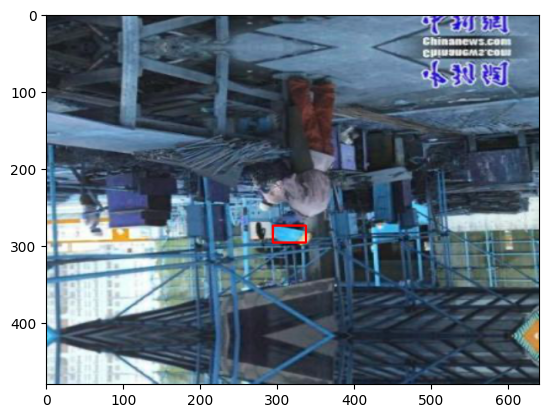

In [12]:
# plot the box round hard hat
cv2.rectangle(augmented_image_resized,
              (denormalized_coords[0], denormalized_coords[1]),
              (denormalized_coords[2], denormalized_coords[3]),
              (255, 0, 0), 2)

plt.imshow(augmented_image_resized)
plt.show()

# Run agumentation pipeline

In [13]:
# This code applys augmentation to each image so we have a big dataset

# directory for aug_data
aug_dir = r'C:\Users\Connor\Desktop\Hard Hat Recongnition\aug_data'

# for loop through data splits
for partition in ['train','test','val']: 
    # read each folders images files
    for image in os.listdir(os.path.join(directory_path, partition, 'images')):
        img = cv2.imread(os.path.join(directory_path, partition, 'images', image))

        coords = [0,0,0.00001,0.00001]
        label_path = os.path.join('data', partition, 'labels', f'{image.split(".")[0]}.json')
        # if json file exists
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                label = json.load(f)
                
            # extract coord from json label
            coords[0] = label['shapes'][0]['points'][0][0]
            coords[1] = label['shapes'][0]['points'][0][1]
            coords[2] = label['shapes'][0]['points'][1][0]
            coords[3] = label['shapes'][0]['points'][1][1]
            # normalise coords
            coords = list(np.divide(coords, [640,480,640,480]))

        try: 
            # perfom data augmentation 60 times per image
            for x in range(60):
                augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])
                cv2.imwrite(os.path.join(aug_dir, partition, 'images', f'{image.split(".")[0]}.{x}.jpg'), augmented['image'])

                annotation = {}
                annotation['image'] = image

                if os.path.exists(label_path):
                    # If there is no bounding box after augmentation, set the values to 0
                    if len(augmented['bboxes']) == 0: 
                        annotation['bbox'] = [0,0,0,0]
                        annotation['class'] = 0 
                    else: 
                        # otherwise use box for augmented data
                        annotation['bbox'] = augmented['bboxes'][0]
                        annotation['class'] = 1
                else: 
                    # if label doesnt exist set to 0
                    annotation['bbox'] = [0,0,0,0]
                    annotation['class'] = 0 

                # save to new dir
                with open(os.path.join(aug_dir, partition, 'labels', f'{image.split(".")[0]}.{x}.json'), 'w') as f:
                    json.dump(annotation, f)

        except Exception as e:
            print(e)

# Load images to tensorlfow datset

In [14]:
# Train images
train_aug_dir_pic = r'C:\Users\Connor\Desktop\Hard Hat Recongnition\aug_data\train\images'
train_images = tf.data.Dataset.list_files(os.path.join(train_aug_dir_pic, '*.jpg'), shuffle=False)
train_images = train_images.map(load_image)
train_images = train_images.map(lambda x: tf.image.resize(x, (120,120)))
train_images = train_images.map(lambda x: x/255)

In [15]:
# Test images
test_aug_dir_pic = r'C:\Users\Connor\Desktop\Hard Hat Recongnition\aug_data\test\images'
test_images = tf.data.Dataset.list_files(os.path.join(test_aug_dir_pic, '*.jpg'), shuffle=False)
test_images = test_images.map(load_image)
test_images = test_images.map(lambda x: tf.image.resize(x, (120,120)))
test_images = test_images.map(lambda x: x/255)

In [16]:
# Val images
val_aug_dir_pic = r'C:\Users\Connor\Desktop\Hard Hat Recongnition\aug_data\val\images'
val_images = tf.data.Dataset.list_files(os.path.join(val_aug_dir_pic, '*.jpg'), shuffle=False)
val_images = val_images.map(load_image)
val_images = val_images.map(lambda x: tf.image.resize(x, (120,120)))
val_images = val_images.map(lambda x: x/255)

In [17]:
train_images.as_numpy_iterator().next()

array([[[0.00341308, 0.00113703, 0.0009585 ],
        [0.00347225, 0.00118146, 0.00107879],
        [0.00350966, 0.0011959 , 0.00106188],
        ...,
        [0.00314708, 0.00173659, 0.00115119],
        [0.00328076, 0.00184076, 0.00128838],
        [0.00309538, 0.00173909, 0.00126134]],

       [[0.00345978, 0.00121197, 0.00100294],
        [0.00340633, 0.00114442, 0.00102073],
        [0.00338608, 0.00113153, 0.00096001],
        ...,
        [0.00316384, 0.00181326, 0.00107582],
        [0.00300195, 0.00166187, 0.00090281],
        [0.00291021, 0.00147137, 0.00079666]],

       [[0.00330979, 0.00113046, 0.00088051],
        [0.00332374, 0.00110984, 0.00093877],
        [0.00332811, 0.00112161, 0.00090721],
        ...,
        [0.00286834, 0.00136157, 0.00072224],
        [0.00280616, 0.00141173, 0.00072447],
        [0.00279563, 0.00139771, 0.00072093]],

       ...,

       [[0.0031065 , 0.00370627, 0.00392157],
        [0.0031065 , 0.00370627, 0.00392157],
        [0.0031061 , 0

In [18]:
# load labels
def load_labels(label_path):
    with open(label_path.numpy(), 'r', encoding = "utf-8") as f:
        label = json.load(f)
    return [label['class']], label['bbox']

In [19]:
# train labels
train_aug_labels = r'C:\Users\Connor\Desktop\Hard Hat Recongnition\aug_data\train\labels'
train_labels = tf.data.Dataset.list_files(os.path.join(train_aug_labels, '*.json'), shuffle=False)
train_labels = train_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [20]:
# test labels
test_aug_labels = r'C:\Users\Connor\Desktop\Hard Hat Recongnition\aug_data\test\labels'
test_labels = tf.data.Dataset.list_files(os.path.join(test_aug_labels, '*.json'), shuffle=False)
test_labels = test_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [21]:
# val labels
val_aug_labels = r'C:\Users\Connor\Desktop\Hard Hat Recongnition\aug_data\val\labels'
val_labels = tf.data.Dataset.list_files(os.path.join(val_aug_labels, '*.json'), shuffle=False)
val_labels = val_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [22]:
train_labels.as_numpy_iterator().next()

(array([0], dtype=uint8), array([0., 0., 0., 0.], dtype=float16))

In [23]:
# count elements for each 
train_images_cardinality = train_images.cardinality().numpy()
train_labels_cardinality = train_labels.cardinality().numpy()
test_images_cardinality = test_images.cardinality().numpy()
test_labels_cardinality = test_labels.cardinality().numpy()
val_images_cardinality = val_images.cardinality().numpy()
val_labels_cardinality = val_labels.cardinality().numpy()

print(train_images_cardinality, train_labels_cardinality, 
      test_images_cardinality, test_labels_cardinality,
     val_images_cardinality, val_labels_cardinality)

4200 4200 900 900 1560 1560


# Final Dataset

In [27]:
# train final dataset
train = tf.data.Dataset.zip((train_images, train_labels)) # zips both datasets toghther
train = train.shuffle(4500) # shuffle amount bigger than count
train = train.batch(8) # batches of 8
train = train.prefetch(4) # eliminate bottleneck

In [28]:
# test final dataset
test = tf.data.Dataset.zip((test_images, test_labels)) 
test = test.shuffle(4500)
test = test.batch(8)
test = test.prefetch(4) 

In [29]:
# val final dataset
val = tf.data.Dataset.zip((val_images, val_labels)) 
val = val.shuffle(4500)
val = val.batch(8) 
val = val.prefetch(4) 

In [36]:
train.as_numpy_iterator().next()[0].shape

(8, 120, 120, 3)

In [ ]:
# shows 8 images / 120 px wide by 120 px high / 3 channels 

# View Images